# SECOND EXERCISE

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import numba
import time
from sklearn.linear_model import LogisticRegression

# 1) Preprocess (centering and normalizing)

Dataset: 10 real features, 1 integer label

In [2]:
data = np.loadtxt("Unsupervised-Learning-Datasets/data_kPCA.txt")
labels = np.loadtxt("Unsupervised-Learning-Datasets/labels_kPCA.txt",dtype=int)

N = data.shape[0]
D = data.shape[1]
print(data.shape,labels.shape)

(10000, 10) (10000,)


In [3]:
data = (data - np.mean(data,axis=0)) / np.std(data,axis=0)

Check that data are now properly centered and normalized:

In [4]:
with np.printoptions(precision=1):
    print("Feature averages after centering:\n\t" + str(np.mean(data,axis=0)))
    print("\nFeature standard deviations after normalization:\n\t" + str(np.std(data,axis=0)))

Feature averages after centering:
	[ 1.4e-15  2.3e-15 -3.6e-16 -6.5e-17  4.6e-16 -7.3e-16  8.2e-17  7.1e-16
  5.7e-16 -2.4e-15]

Feature standard deviations after normalization:
	[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


# 2) Splitting of the dataset into test set and learning set

In [5]:
data_test = data[:1000,:]
data_learning = data[1000:,:]
labels_test = labels[:1000]
labels_learning = labels[1000:]

N_learning = data_learning.shape[0] # 9000
N_test = data_test.shape[0] # 9000
print("Dimension of test set: " + str(data_test.shape[0]))
print("Dimension of learning set: " + str(data_learning.shape[0]))

Dimension of test set: 1000
Dimension of learning set: 9000


# 3) Principal Component Analysis
We want to compute the Principal Components (PCs)
\begin{equation}
    \widetilde{Y}_k^{\,i}=\sum_\alpha A_{k\alpha}X_\alpha^i\,,
\end{equation}
where $k=1,...,d$ and $A_{k\alpha}$ is the $\alpha$ component of the $k$-th eigenvector of the covariance matrix $C$ defined below:
\begin{equation}
    \mathbf{C}\,\mathbf{A}_k = \lambda_k \mathbf{A}_k\,.
\end{equation}
### 3.1) Covariance matrix C
$A_{k\alpha}$ are the normalized eigenvectors of the covariance matrix $\mathbf{C}$:
\begin{equation}
    C_{\alpha\beta} = \frac{1}{N}\sum_{i}X_\alpha^i X_\beta^i = \frac{1}{9000}\sum_{i=1}^{9000} X_\alpha^i X_\beta^i\,,
\end{equation}
which has dimensions $D\times D = 10\times 10$.

In [6]:
covariance_X = np.zeros((D,D))
for D1 in range(D):
    for D2 in range(D):
        covariance_X[D1,D2] = np.sum(data_learning[:,D1]*data_learning[:,D2]) / N_learning

### 3.2) Eigenvalue problem for C

In [7]:
eigenvalues, eigenvectors = np.linalg.eigh(covariance_X) # optimized for symmetric real matrices
eigenvalues = np.flip(eigenvalues)  # by default in ascending order
eigenvectors = np.flip(eigenvectors,axis=1)

Let's plot the eigenvalues of $\mathbf{C}$ together woith the quality factor $q_k$, defined as
\begin{equation}
   q_k = \frac{\sum_{l=1}^k\lambda_l}{\sum_{l=1}^D\lambda_l}
\end{equation}

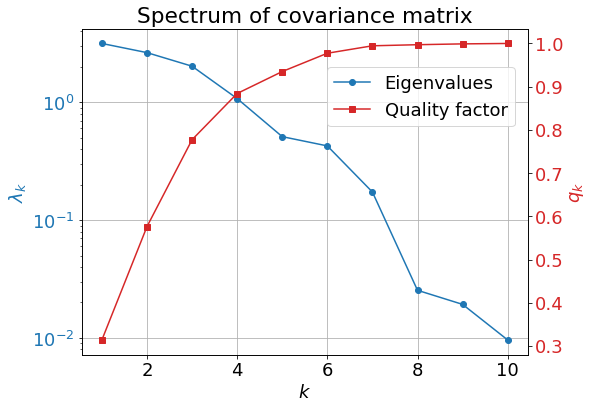

In [8]:
plt.rcParams['font.size'] = 18
fig, ax1 = plt.subplots(figsize=(8,6))

color = 'tab:blue'
lns1 = ax1.plot(np.arange(1,D+1),eigenvalues,'o-',color=color,label="Eigenvalues")
ax1.set(xlabel="$k$",title="Spectrum of covariance matrix",yscale="log")
ax1.set_ylabel(ylabel="$\\lambda_k$",color=color)
ax1.grid("on")
ax1.tick_params(axis='y', labelcolor=color)

color = 'tab:red'
ax2 = ax1.twinx()  
lns2 = ax2.plot(np.arange(1,D+1),np.cumsum(eigenvalues)/np.sum(eigenvalues),'s-',color=color,label="Quality factor")
ax2.set_ylabel("$q_k$",color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax1.legend()

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=[0.55,0.7])

plt.rcParams['font.size'] = 18        
plt.show()

In [14]:
q2 = (eigenvalues[0] + eigenvalues[1]) / np.sum(eigenvalues)
print("q2 = " + "{:.5f}".format(q2))

q2 = 0.57610


### 3.3) Project data in the two first PCs and color it by label
Let's perform a dimensional reduction with $d=2$, namely to the reduced variables
\begin{align}
    \widetilde{Y}_1^{\,i} &= \sum_\alpha A_{1\alpha}X_\alpha^i\,, \\
    \widetilde{Y}_2^{\,i} &= \sum_\alpha A_{2\alpha}X_\alpha^i\,.
\end{align}

Check that the eigenvectors are orthonormal:

In [15]:
print("Norms of the first two eigenvectors: {:.6f}\t{:.6f}".format(np.linalg.norm(eigenvectors[:,0]),np.linalg.norm(eigenvectors[:,1])))
print("Scalar product of the first two eigenvectors: {:.4g}".format(np.dot(eigenvectors[:,0],eigenvectors[:,1])))

Norms of the first two eigenvectors: 1.000000	1.000000
Scalar product of the first two eigenvectors: -1.943e-16


Then we compute the PCs of the data (both in training and test sets):

In [16]:
Y_learning = np.zeros((N_learning,D)) # Y_i,k (First component: data point label; second component: # of PC,)
Y_test = np.zeros((N_test,D))
for k in range(D):
    for i in range(N_learning):
        Y_learning[i,k] = np.dot(eigenvectors[:,k],data_learning[i,:])
    for i in range(N_test):
        Y_test[i,k] = np.dot(eigenvectors[:,k],data_test[i,:])

Plot the two first PCs and color them by the label:

In [17]:
distinct_labels = []
labels_indices = {}
for i in range(N_learning):
    label = labels_learning[i]
    if (label not in distinct_labels): 
        distinct_labels.append(label)
        labels_indices[label] = []
    labels_indices[label].append(i)
    
distinct_labels = np.array(np.sort(distinct_labels),dtype=int)       
print("Distinct labels: " + str(np.sort(distinct_labels)))

Distinct labels: [0 1 2 3]


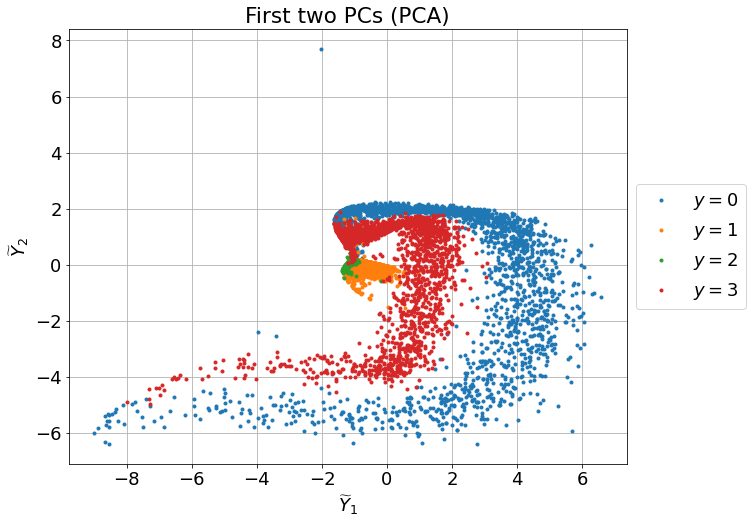

In [19]:
plt.figure(figsize=(10,8))

for label in distinct_labels:
    indices = labels_indices[label]
    plt.plot(Y_learning[indices,0],Y_learning[indices,1],'.',label="$y = $" + str(label))
plt.xlabel("$\widetilde{Y}_1$")
plt.ylabel("$\widetilde{Y}_2$")
plt.grid("on")
plt.title("First two PCs (PCA)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# 4) Multinomial logistic regression for increasing number of PCs

The mutual information between the RVs $y_1$ and $y_2$ is defined as
\begin{equation}
    I(y_1,y_2) = \sum_{y_1,y_2} \mathcal{P}(y_1,y_2)\log\left(\frac{\mathcal{P}(y_1,y_2)}{\mathcal{P}(y_1)\mathcal{P}(y_2)} \right)\,,
\end{equation}
where $\mathcal{P}(y_1,y_2)$ is the joint probability distributions of variables $y_1,\,y_2$ and $\mathcal{P}(y_1),\,\mathcal{P}(y_2)$ are the marginal distributions. The normalized mutual information is:
\begin{equation}
    NMI(y_1,y_2) = \frac{2\,I(y_1,y_2)}{H(y_1) + H(y_2)}\in \left[0,1\right]\,,
\end{equation}
where $H(y_1),\,H(y_2)$ are the Shannon entropies of $y_1,\,y_2$:
\begin{equation}
    H(y) = - \sum_y \mathcal{P}(y)\log\mathcal{P}(y)\,.
\end{equation}

In [20]:
def compute_mutual_info(y1,y2):

    nsamples = len(y1)
    p_y1 = np.zeros(4)
    p_y2 = np.zeros(4)
    p_joint = np.zeros((4,4))
    
    for j in range(nsamples):
        p_y1[y1[j]] += 1.
        p_y2[y2[j]] += 1.
        p_joint[y1[j],y2[j]] += 1.
    
    p_y1 /= nsamples
    p_y2 /= nsamples
    p_joint /= nsamples

    I = 0
    for y1_i in [0,1,2,3]:
        for y2_j in [0,1,2,3]:
            if p_joint[y1_i,y2_j] != 0:
                I += p_joint[y1_i,y2_j]*np.log(p_joint[y1_i,y2_j]/(p_y1[y1_i]*p_y2[y2_j]))
    
    # compute normalized mutual information
    entropy1 = -np.sum(p_y1*np.log(p_y1))
    entropy2 = -np.sum(p_y2*np.log(p_y2))
    I_normalized = 2*I / (entropy1+entropy2)
                
    return I, I_normalized
    
# scikitkearn function:
    #from sklearn.feature_selection import mutual_info_classif
    #from sklearn.metrics import normalized_mutual_info_score
    #return mutual_info_classif(y1.reshape(-1,1), y2, discrete_features = True)[0], normalized_mutual_info_score(y1, y2)

Let's apply a multinomial logistic regression using the PCs of the data in the learning set and the corresponding labels, for an increasing number of PCs $k\in[1,10]$. After that, the multinomial model is applied on the PCs of the test set and the predicted labels are compared with the ground-truth ones, by computing the mutual information as a function of $k$.

In [21]:
k_values = range(1,11)
mutual_info_PCA = []
mutual_info_normalized_PCA = []
for k in k_values:
    PCs_learning = Y_learning[:,:k]
    PCs_test = Y_test[:,:k]
    
    # apply multinomial logistic regression in the learning data set, using k PCs
    model = (LogisticRegression(random_state=0, multi_class='multinomial', penalty='none', 
                                solver='newton-cg').fit(PCs_learning,labels_learning))
    
    # make a prediction based on the logistic model using the PCs computed over the test set
    labels_predicted = model.predict(PCs_test)
    
    results = compute_mutual_info(labels_predicted,labels_test)
    mutual_info_PCA.append(results[0])
    mutual_info_normalized_PCA.append(results[1])

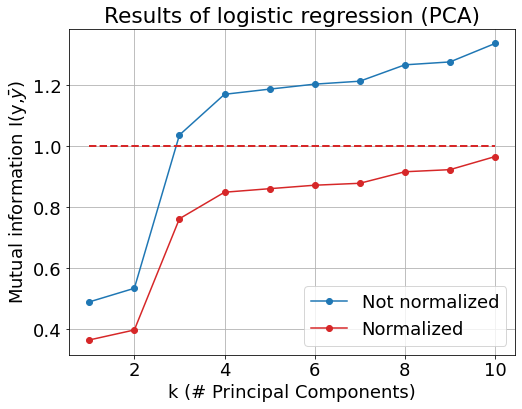

In [22]:
plt.figure(figsize=(8,6))
plt.plot(np.arange(1,D+1),mutual_info_PCA,'o-',label="Not normalized")
plt.plot(np.arange(1,D+1),mutual_info_normalized_PCA,'o-',label="Normalized",color='tab:red')
plt.plot(np.arange(1,D+1),np.ones(D),'--',color='tab:red',linewidth=2)
plt.xlabel("k (# Principal Components)")
plt.ylabel("Mutual information I(y,$\\bar{y}$)")
plt.legend()
plt.title("Results of logistic regression (PCA)")
plt.grid("on")

# 5) Kernel-PCA with Gaussian Kernel
- Compute Gaussian kernel matrix $K^{ij} = \exp\left(-\|X^i-X^j \|\,/\, 2\sigma^2\right)\,/ \,\sqrt{2\pi\sigma^2}$
- Compute Gram matrix $G^{ij}$ by double-centering: $G^{ij} = K^{ij} - \frac{1}{N}\sum_l \left(G^{il} + G^{jl} \right) + \frac{1}{N^2}\sum_{l,m}K^{lm}$
- Diagonalize Gram matrix: $\sum_{j}G^{ij}\,Y_k^j = \lambda_k Y_k^i$
- Compute reduced variables: $\sqrt{\lambda_k}\,Y_k^j$

In [30]:
# compute average distance of the nearest neighbour of the specified input order
@numba.njit(fastmath=True)
def average_distance_nn(data,order=5): 
    N = data.shape[0]
    distances_nn = []
    for i in range(N):
        d_ij = []
        for j in range(N):
            d_ij.append(np.linalg.norm(data[i,:]-data[j,:]))
        distances_nn.append(np.partition(d_ij,order)[order]) # partition orders a subset of input elements
    return np.mean(np.array(distances_nn))                   # N.B. position 0 is for the element itself!

# applies gaussian kernel to a pair of data points, using width sigma
@numba.njit(fastmath=True)
def gaussian_kernel(X1,X2,sigma):
    return np.exp(-np.linalg.norm(X1-X2)**2/(2*sigma**2))

# computes the kernel matrix employing its symmetry
@numba.njit(fastmath=True)
def compute_kernel_matrix(data,sigma):
    N = data.shape[0]
    kernel_matrix = np.zeros((N,N)) 
    for i in range(N):
        kernel_matrix[i,i] = 0.5 # diagonal elements are 1 (after summing transpose)
        for j in range(i+1,N):
            kernel_matrix[i,j] = gaussian_kernel(data[i,:],data[j,:],sigma=sigma)
    kernel_matrix += kernel_matrix.T
    return kernel_matrix

# computes the Gram matrix from the kernel (or distance) matrix using double-centering
@numba.njit(fastmath=True)
def double_centering(K,case='kernel'):
    N = K.shape[0]
    gram_matrix = np.zeros((N,N))
    average_K = np.sum(K)/N**2
    for i in range(N):
        gram_matrix[i,i] = 0.5*(K[i,i]-2.0/N*np.sum(K[i,:])+average_K)
        for j in range(i+1,N):
            gram_matrix[i,j] = K[i,j]-1.0/N*np.sum(K[i,:]+K[j,:])+average_K
    gram_matrix += gram_matrix.T
    
    if case != 'kernel':
        gram_matrix *= -0.5
        
    return gram_matrix

We take as width $\sigma$ for the Gaussian kernel the average distance of the 5th nearest neighbor:

In [31]:
numbers_nn = [5,50,100]
sigmas = []
for order in numbers_nn:
    sigmas.append(average_distance_nn(data,order=order))
    print("Average distance of " + str(order) + "th nearest neighbor: " + "{:.3f}".format(sigmas[-1]))

Average distance of 5th nearest neighbor: 0.168
Average distance of 50th nearest neighbor: 0.509
Average distance of 100th nearest neighbor: 0.699


Compute kernel matrix $\mathbf{K}$ using Gaussian kernel, namely
\begin{equation}
    K^{ij} = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(-\frac{\| X^i-X^j \|^2}{2\sigma^2}\right)
\end{equation}

In [32]:
kernel_matrix = {}
for sigma in sigmas:
    kernel_matrix[sigma] = compute_kernel_matrix(data,sigma)

Compute Gram matrix $\mathbf{G}$ from Kernel matrix $\mathbf{K}$ by double-centering:
\begin{equation}
    G^{ij} = K^{ij} - \frac{1}{N}\sum_l \left(G^{il} + G^{jl} \right) + \frac{1}{N^2}\sum_{l,m}K^{lm}
\end{equation}

In [33]:
start_time = time.time()

gram_matrix = {}
for sigma in sigmas:
    gram_matrix[sigma] = double_centering(kernel_matrix[sigma],case='kernel')
    
print("Execution time: {:.1f} minutes".format((time.time() - start_time)/60))

Execution time: 13.4 minutes


Check that G has satisfies the main property of a Gram matrix, namely 
\begin{equation}
    \sum_j G^{ij} = \sum_i G^{ij} = 0\hspace{0.4cm}\forall i,j\,.
\end{equation}

In [36]:
for sigma in sigmas:
    zero_sums = True
    for raw in range(gram_matrix[sigma].shape[0]):
        zero_sums *= (np.abs(np.sum(gram_matrix[sigma][raw,:])) < 1e-8)
    print("sigma = {:.3f}".format(sigma)+": is Gram matrix property satisfied within numerical accuracy? " + str(bool(zero_sums)))

sigma = 0.168: is Gram matrix property satisfied within numerical accuracy? True
sigma = 0.509: is Gram matrix property satisfied within numerical accuracy? True
sigma = 0.699: is Gram matrix property satisfied within numerical accuracy? True


### 5.1) Eigenvalue problem for G
Let's solve the eigenvalue problem for $\mathbf{G}$, namely
\begin{equation}
    \sum_{j=1}^N G^{ij}Y_l^j = \lambda_l Y_l^j
\end{equation}

In [44]:
start_time = time.time()

k_max = 100
eigenvalues_kPCA = {}
eigenvectors_kPCA = {}
for sigma in sigmas:
    eigenvalues_kPCA[sigma], eigenvectors_kPCA[sigma] = scipy.linalg.eigh(gram_matrix[sigma],
                                                                          subset_by_index=[N-k_max,N-1]) 
    eigenvalues_kPCA[sigma] = np.flip(eigenvalues_kPCA[sigma])  # by default in ascending order
    eigenvectors_kPCA[sigma] = np.flip(eigenvectors_kPCA[sigma],axis=1)

print("Execution time: {:.1f} minutes".format((time.time() - start_time)/60))

Execution time: 2.0 minutes


Let's plot the eigenvalues of $\mathbf{G}$ together woith the quality factor $q_k$:

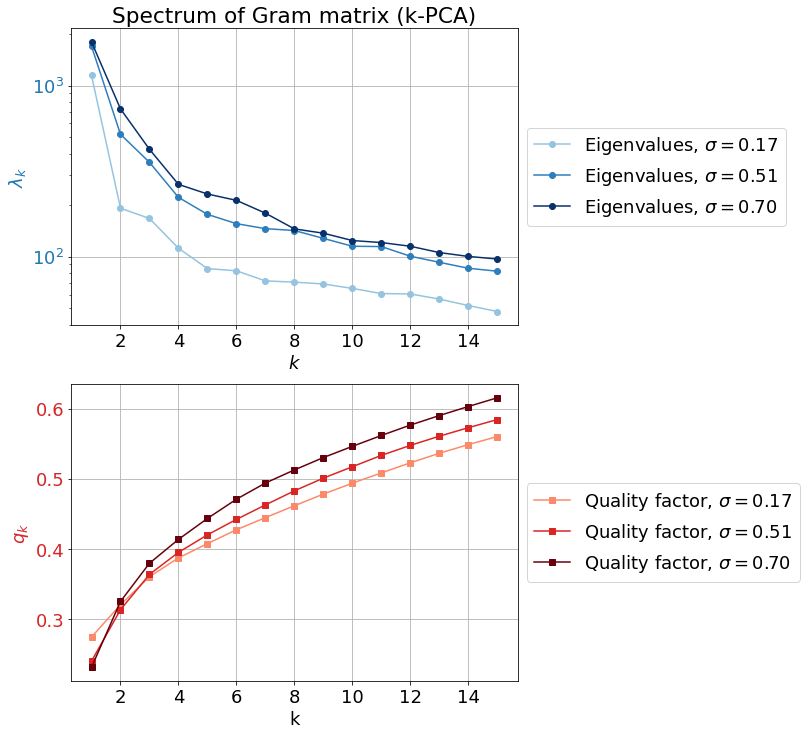

In [51]:
plt.rcParams['font.size'] = 18
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,12))
k_max = 15

colors = plt.cm.Blues(np.linspace(0.4,1.,3))
i = 0
lns = {}
for sigma in sigmas:
    ax1.plot(np.arange(1,k_max+1),eigenvalues_kPCA[sigma][:k_max],'o-',
                      color=colors[i],label="Eigenvalues, $\sigma = {:.2f}$".format(sigma))
    i+=1
ax1.set(xlabel="$k$",title="Spectrum of Gram matrix (k-PCA)",yscale="log")
ax1.set_ylabel(ylabel="$\\lambda_k$",color='tab:blue')
ax1.grid("on")
ax1.tick_params(axis='y',labelcolor='tab:blue')
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

colors = plt.cm.Reds(np.linspace(0.4,1.,3))
for sigma in sigmas:
    ax2.plot(np.arange(1,k_max+1),np.cumsum(eigenvalues_kPCA[sigma][:k_max])/np.sum(eigenvalues_kPCA[sigma]),
                's-',color=colors[i-3],label="Quality factor, $\sigma = {:.2f}$".format(sigma))
    i+=1
ax2.set_ylabel("$q_k$",color='tab:red')
ax2.set_xlabel("k")
ax2.tick_params(axis='y',labelcolor='tab:red')
ax2.grid("on")
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.subplots_adjust(hspace=0.2)
plt.show()

In [52]:
for sigma in sigmas:
    q2 = (eigenvalues_kPCA[sigma][0] + eigenvalues_kPCA[sigma][1]) / np.sum(eigenvalues_kPCA[sigma])
    print("q2 = " + "{:.5f}".format(q2))

q2 = 0.32023
q2 = 0.31323
q2 = 0.32496


### 5.2) Project data in the two first PCs and color it by label
With kPCA, the k-th component of the data point $i$ is given by:
\begin{align}
    \widehat{Y}_k^i &= \sqrt{\lambda_k}\,Y_k^i\,.
\end{align}

In [53]:
k_max = 10
N = len(data)
Y_kPCA = {}
for sigma in sigmas:
    Y_kPCA[sigma] = np.zeros((N,k_max)) # Y_j,k (first component: # of PC, second component: data point label)
    for k in range(k_max):
        Y_kPCA[sigma][:,k] = eigenvectors_kPCA[sigma][:,k]*np.sqrt(eigenvalues_kPCA[sigma][k])

Plot the two first PCs and color them by the level:

In [54]:
distinct_labels = []
labels_indices = {}
for i in np.arange(N):
    label = labels[i]
    if (label not in distinct_labels): 
        distinct_labels.append(label)
        labels_indices[label] = []
    labels_indices[label].append(i)
    
distinct_labels = np.array(np.sort(distinct_labels),dtype=int)       
print("Distinct labels: " + str(np.sort(distinct_labels)))

Distinct labels: [0 1 2 3]


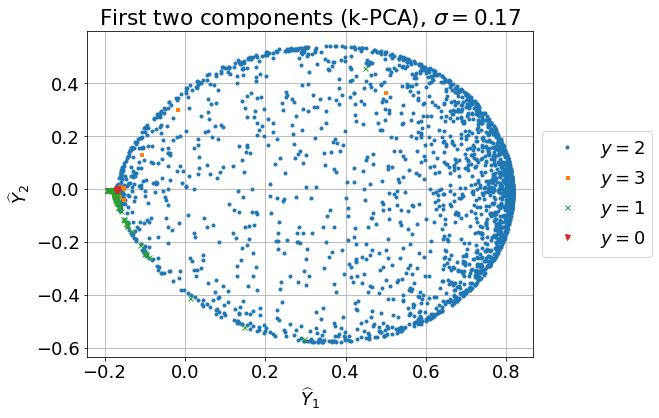

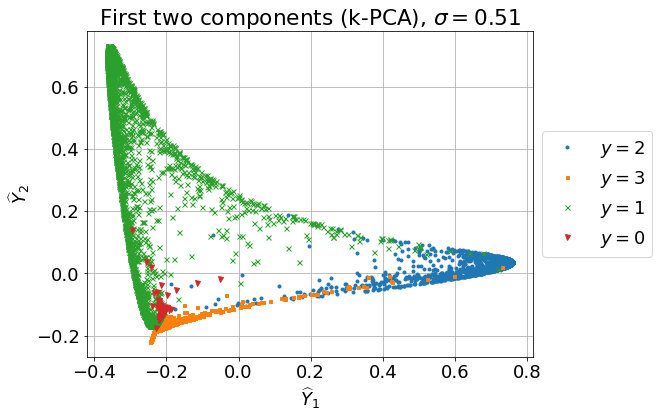

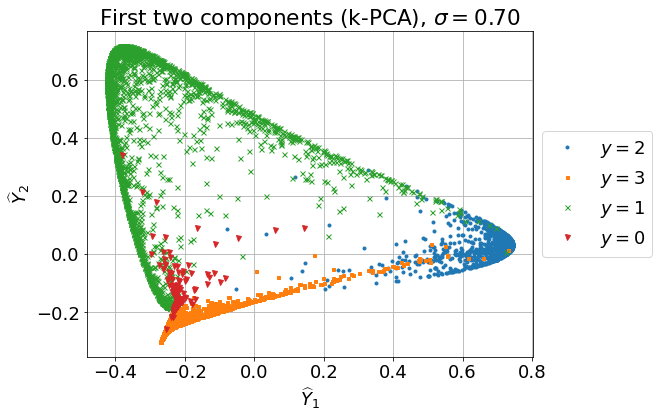

In [55]:
for sigma in sigmas:   
    plt.figure(figsize=(8,6))
    plt.rcParams['font.size'] = 18

    markers = ['o','s','x','v']
    markersizes = [3,3,5,5]
    i = 0
    for label in [2,3,1,0]:
        indices = labels_indices[label]
        (plt.plot(Y_kPCA[sigma][indices,0],Y_kPCA[sigma][indices,1],markers[i],markersize=markersizes[i],
                  label="$y = $" + str(label)))
        i += 1

    plt.xlabel("$\widehat{Y}_1$")
    plt.ylabel("$\widehat{Y}_2$")
    plt.grid("on")
    plt.title("First two components (k-PCA), $\sigma = {:.2f}$".format(sigma))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

### 5.3) Multinomial logistic regression for increasing number of PCs

In [56]:
k_values = range(1,11)
mutual_info_kPCA = {}
mutual_info_normalized_kPCA = {}
for sigma in sigmas:
    mutual_info_kPCA[sigma] = []
    mutual_info_normalized_kPCA[sigma] = []
    for k in k_values:
        PCs_test = Y_kPCA[sigma][:1000,:k]
        PCs_learning = Y_kPCA[sigma][1000:,:k]

        # apply multinomial logistic regression in the learning data set, using k PCs
        model = (LogisticRegression(random_state=0, multi_class='multinomial', penalty='none', 
                                    solver='newton-cg').fit(PCs_learning,labels_learning))

        # make a prediction based on the logistic model using the PCs computed over the test set
        labels_predicted = model.predict(PCs_test)

        results = compute_mutual_info(labels_predicted,labels_test)
        mutual_info_kPCA[sigma].append(results[0])
        mutual_info_normalized_kPCA[sigma].append(results[1])

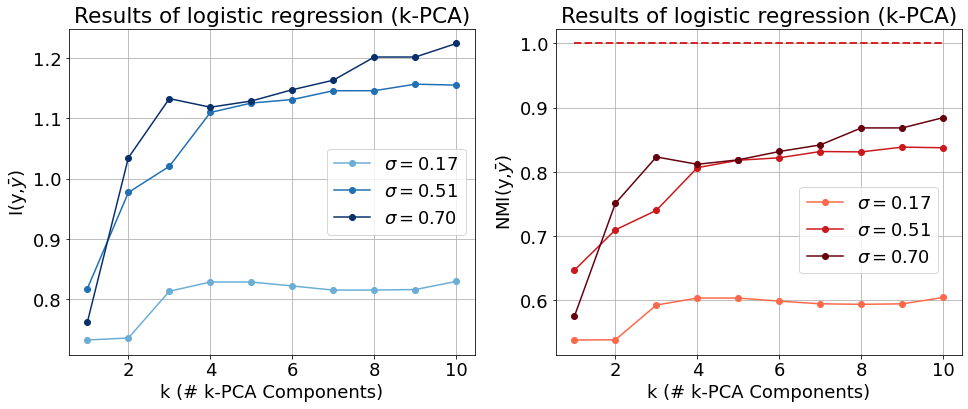

In [57]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,6))

blues = plt.cm.Blues(np.linspace(0.5,1.,3))
reds = plt.cm.Reds(np.linspace(0.5,1.,3))
i = 0
for sigma in sigmas:
    ax1.plot(np.arange(1,D+1),mutual_info_kPCA[sigma],'o-',color=blues[i],label="$\sigma = {:.2f}$".format(sigma))
    ax2.plot(np.arange(1,D+1),mutual_info_normalized_kPCA[sigma],'o-',color=reds[i],label="$\sigma = {:.2f}$".format(sigma))
    i += 1
ax2.plot(np.arange(1,D+1),np.ones(D),'--',color='tab:red',linewidth=2)
ax1.set(xlabel="k (# k-PCA Components)",ylabel="I(y,$\\bar{y}$)",
        title="Results of logistic regression (k-PCA)")
ax2.set(xlabel="k (# k-PCA Components)",ylabel="NMI(y,$\\bar{y}$)",
        title="Results of logistic regression (k-PCA)")
ax1.legend(loc='best')
ax2.legend(loc=(0.6,0.25))
ax1.grid("on")
ax2.grid("on")

# 6) ISOMAP
$\Delta_{ij}$: estimate of geodetic distance by means of Floyd algorithm

In [58]:
# Initialize distance graph by linking each point to 'nn_cutoff' nearest neighbors, and setting to infinity
# all the remaining distances
def initialize_graph(data,nn_cutoff=5):
    N = data.shape[0]
    distance_matrix = np.zeros((N,N))
    for i in range(N):
        for j in range(i+1,N):
            distance_matrix[i,j] = np.linalg.norm(data[i,:]-data[j,:])
    distance_matrix += distance_matrix.T
    
    distance_graph = np.inf * np.ones((N,N))
    for i in range(N):                                                   
        #indices_nn_of_i = np.argsort(distance_matrix[i,:],kind='stable')[:nn_cutoff+1]
        indices_nn_of_i = np.argpartition(distance_matrix[i,:],range(nn_cutoff+1))[:nn_cutoff+1]
        for j in indices_nn_of_i:
            distance_graph[i,j] = distance_graph[j,i] = distance_matrix[i,j]
    return distance_graph

# Floyd algorithm to estimate pair-wise geodetic distances
@numba.njit(fastmath=True)
def floyd_algorithm(distance_graph):
    N = distance_graph.shape[0]
    for k in range(N):
        for i in range(N):
            for j in range(N):
                if (distance_graph[i,j] > distance_graph[i,k] + distance_graph[k,j]):
                    distance_graph[i,j] = distance_graph[i,k] + distance_graph[k,j]
    return distance_graph

Initialize the graph connecting each point to the 5 nearest neighbor points:

In [59]:
start_time = time.time()
distance_graph = initialize_graph(data,nn_cutoff=5)
print("Execution time: {:.1f} minutes".format((time.time() - start_time)/60))

Execution time: 3.3 minutes


Apply Floyd algorithm to estimate geodetic distance graph:

In [60]:
start_time = time.time()
distance_graph = floyd_algorithm(distance_graph)
print("Execution time: {:.1f} minutes".format((time.time() - start_time)/60))

Execution time: 12.5 minutes


Check that the graph is connected, i.e. there are no infinities:

In [61]:
connected = not np.isinf(distance_graph).any()
if connected: print("The graph is connected")
else: print("The graph is not connected")

The graph is connected


Compute Gram matrix by double centering the distance matrix (squared) $\Delta_{ij}$, namely:
\begin{equation}
    G^{ij} = -\frac{1}{2}\left(\Delta^{ij} - \frac{1}{N}\sum_l \left(\Delta^{il} + \Delta^{jl} \right) + \frac{1}{N^2}\sum_{l,m}\Delta^{lm}\right)
\end{equation}

In [62]:
start_time = time.time()
gram_matrix = double_centering(distance_graph**2, case='isomap')
print("Execution time: {:.1f} minutes".format((time.time() - start_time)/60))

Execution time: 4.5 minutes


Check that G has satisfies the main property of a Gram matrix:

In [63]:
zero_sums = True
for raw in range(gram_matrix.shape[0]):
    zero_sums *= (np.abs(np.sum(gram_matrix[raw,:])) < 1e-8)
print("Is Gram matrix property satisfied within numerical accuracy? " + str(bool(zero_sums)))

Is Gram matrix property satisfied within numerical accuracy? True


### 6.1) Eigenvalue problem for G
Let's solve the eigenvalue problem for $\mathbf{G}$, namely
\begin{equation}
    \sum_{j=1}^N G^{ij}Y_l^j = \lambda_l Y_l^j
\end{equation}

In [64]:
# optimized routine for symmetric real matrices, returning only the first k_max eigenvalues and eigenvectors
k_max = 100
eigenvalues_isomap, eigenvectors_isomap = scipy.linalg.eigh(gram_matrix,subset_by_index=[10000-k_max, 10000-1])
eigenvalues_isomap = np.flip(eigenvalues_isomap)  # by default in ascending order
eigenvectors_isomap = np.flip(eigenvectors_isomap,axis=1)

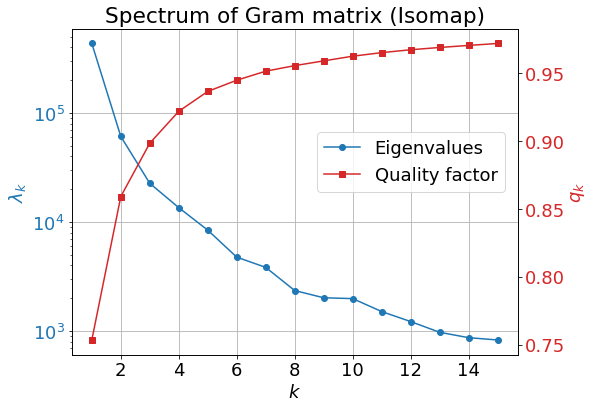

In [65]:
plt.rcParams['font.size'] = 18
fig, ax1 = plt.subplots(figsize=(8,6))
k_max = 15

color = 'tab:blue'
lns1 = ax1.plot(np.arange(1,k_max+1),eigenvalues_isomap[:k_max],'o-',color=color,label="Eigenvalues")
ax1.set(xlabel="$k$",title="Spectrum of Gram matrix (Isomap)",yscale="log")
ax1.set_ylabel(ylabel="$\\lambda_k$",color=color)
ax1.grid("on")
ax1.tick_params(axis='y', labelcolor=color)

color = 'tab:red'
ax2 = ax1.twinx()  
lns2 = ax2.plot(np.arange(1,k_max+1),np.cumsum(eigenvalues_isomap[:k_max])/np.sum(eigenvalues_isomap),'s-',
                color=color,label="Quality factor")
ax2.set_ylabel("$q_k$",color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax1.legend()

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=[0.55,0.5])
        
plt.show()

In [66]:
q2 = (eigenvalues_isomap[0] + eigenvalues_isomap[1]) / np.sum(eigenvalues_isomap)
print("q2 = " + "{:.5f}".format(q2))

q2 = 0.85918


### 6.2) Project data into the two first PCs and color it by label

In [67]:
k_max = 10
N = len(data)
Y_isomap = np.zeros((N,k_max)) # Y_j,k (first component: # of PC, second component: data point label)
for k in range(k_max):
    Y_isomap[:,k] = eigenvectors_isomap[:,k]*np.sqrt(eigenvalues_isomap[k])

In [68]:
distinct_labels = []
labels_indices = {}
for i in np.arange(N):
    label = labels[i]
    if (label not in distinct_labels): 
        distinct_labels.append(label)
        labels_indices[label] = []
    labels_indices[label].append(i)
    
distinct_labels = np.array(np.sort(distinct_labels),dtype=int)       
print("Distinct labels: " + str(np.sort(distinct_labels)))

Distinct labels: [0 1 2 3]


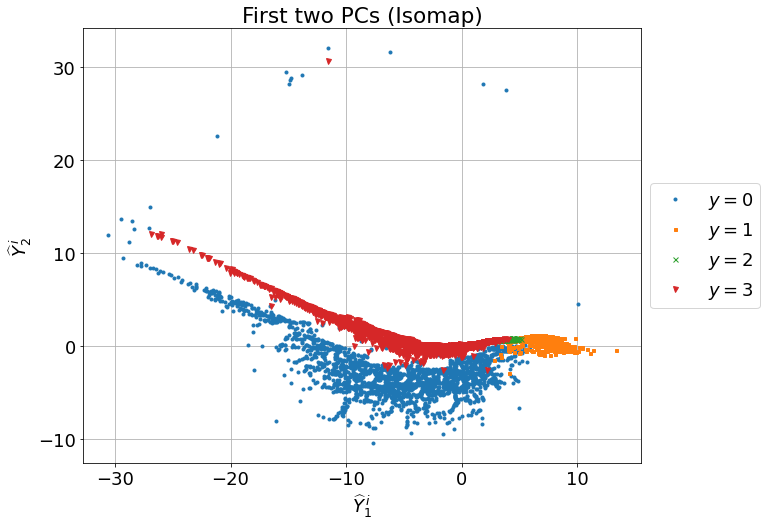

In [69]:
plt.figure(figsize=(10,8))
plt.rcParams['font.size'] = 18

markers = ['o','s','x','v']
markersizes = [3,3,5,5]
i = 0
for label in distinct_labels:
    indices = labels_indices[label]
    plt.plot(Y_isomap[indices,0],Y_isomap[indices,1],markers[i],markersize=markersizes[i],
             label="$y = $" + str(label))
    i += 1
plt.xlabel("$\widehat{Y}_1^{\,i}$")
plt.ylabel("$\widehat{Y}_2^{\,i}$")
plt.grid("on")
plt.title("First two PCs (Isomap)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### 5.3) Multinomial logistic regression for increasing number of PCs

In [70]:
k_values = range(1,11)
mutual_info_isomap = []
mutual_info_normalized_isomap = []
for k in k_values:
    PCs_test = Y_isomap[:1000,:k]
    PCs_learning = Y_isomap[1000:,:k]
    
    # apply multinomial logistic regression in the learning data set, using k PCs
    model = (LogisticRegression(random_state=0, multi_class='multinomial', penalty='none', 
                                solver='newton-cg').fit(PCs_learning,labels_learning))
    
    # make a prediction based on the logistic model using the PCs computed over the test set
    labels_predicted = model.predict(PCs_test)
    
    results = compute_mutual_info(labels_predicted,labels_test)
    mutual_info_isomap.append(results[0])
    mutual_info_normalized_isomap.append(results[1])

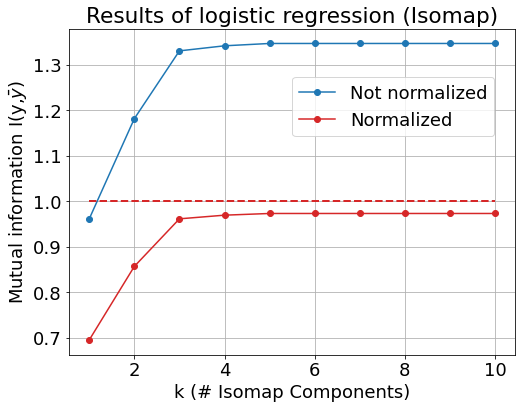

In [71]:
plt.figure(figsize=(8,6))
plt.plot(np.arange(1,D+1),mutual_info_isomap,'o-',label="Not normalized")
plt.plot(np.arange(1,D+1),mutual_info_normalized_isomap,'o-',label="Normalized",color='tab:red')
plt.plot(np.arange(1,D+1),np.ones(D),'--',color='tab:red',linewidth=2)
plt.xlabel("k (# Isomap Components)")
plt.ylabel("Mutual information I(y,$\\bar{y}$)")
plt.legend(loc=(0.5,0.67))
plt.title("Results of logistic regression (Isomap)")
plt.grid("on")

## Comparison of the methods: PCA vs k-PCA vs Isomap

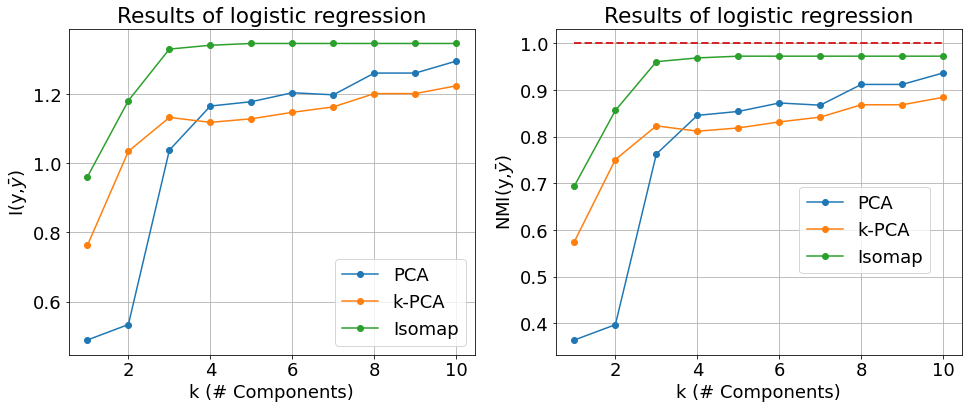

In [72]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,6))

ax1.plot(np.arange(1,D+1),mutual_info_PCA,'o-',label="PCA")
ax2.plot(np.arange(1,D+1),mutual_info_normalized_PCA,'o-',label="PCA")

sigma = sigmas[-1]
ax1.plot(np.arange(1,D+1),mutual_info_kPCA[sigma],'o-',label="k-PCA")
ax2.plot(np.arange(1,D+1),mutual_info_normalized_kPCA[sigma],'o-',label="k-PCA")

ax1.plot(np.arange(1,D+1),mutual_info_isomap,'o-',label="Isomap")
ax2.plot(np.arange(1,D+1),mutual_info_normalized_isomap,'o-',label="Isomap")

ax2.plot(np.arange(1,D+1),np.ones(D),'--',color='tab:red',linewidth=2)
ax1.set(xlabel="k (# Components)",ylabel="I(y,$\\bar{y}$)",
        title="Results of logistic regression")
ax2.set(xlabel="k (# Components)",ylabel="NMI(y,$\\bar{y}$)",
        title="Results of logistic regression")
ax1.legend(loc='best')
ax2.legend(loc=(0.6,0.25))
ax1.grid("on")
ax2.grid("on")

# 7) Repeat the exercise for the Anuran data set

In [73]:
# load and shuffle data and labels
rng = np.random.default_rng(1998)
data = np.loadtxt("Frogs_MFCCs.csv",delimiter=',',skiprows=1,usecols=range(22))
rng.shuffle(data)

rng = np.random.default_rng(1998)
labels = np.loadtxt("Frogs_MFCCs.csv",dtype=str,delimiter=',',skiprows=1,usecols=22)
rng.shuffle(labels)

print(data.shape,labels.shape)

(7195, 22) (7195,)


In [74]:
data = (data - np.mean(data,axis=0)) / np.std(data,axis=0)

In [75]:
N = data.shape[0]
N_test = data.shape[0] // 10
N_learning = data.shape[0] - N_test

data_test = data[:N_test,:]
data_learning = data[N_test:,:]

labels_test = labels[:N_test]
labels_learning = labels[N_test:]

## 7.1) PCA

In [76]:
D = data.shape[1] # 22
covariance_X = np.zeros((D,D))
for D1 in range(D):
    for D2 in range(D):
        covariance_X[D1,D2] = np.sum(data_learning[:,D1]*data_learning[:,D2]) / N_learning

In [77]:
eigenvalues, eigenvectors = np.linalg.eigh(covariance_X) # optimized for symmetric real matrices
eigenvalues = np.flip(eigenvalues)  # by default in ascending order
eigenvectors = np.flip(eigenvectors,axis=1)

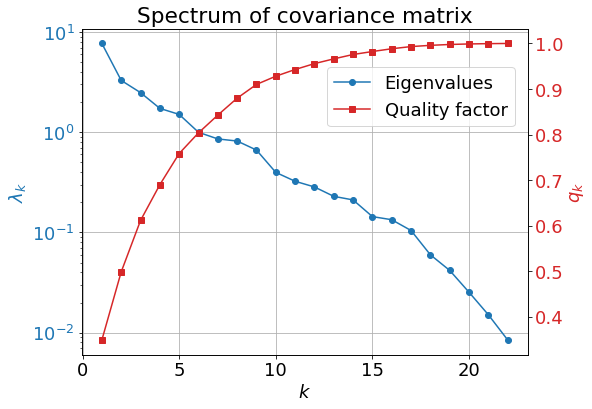

In [79]:
fig, ax1 = plt.subplots(figsize=(8,6))
plt.rcParams['font.size'] = 18

color = 'tab:blue'
lns1 = ax1.plot(np.arange(1,D+1),eigenvalues,'o-',color=color,label="Eigenvalues")
ax1.set(xlabel="$k$",title="Spectrum of covariance matrix",yscale="log")
ax1.set_ylabel(ylabel="$\\lambda_k$",color=color)
ax1.grid("on")
ax1.tick_params(axis='y', labelcolor=color)

color = 'tab:red'
ax2 = ax1.twinx()  
lns2 = ax2.plot(np.arange(1,D+1),np.cumsum(eigenvalues)/np.sum(eigenvalues),'s-',color=color,label="Quality factor")
ax2.set_ylabel("$q_k$",color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax1.legend()

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=[0.55,0.7])
        
plt.show()

In [80]:
q2 = (eigenvalues[0] + eigenvalues[1]) / np.sum(eigenvalues)
print("q2 = " + "{:.5f}".format(q2))

q2 = 0.49860


In [81]:
Y_learning = np.zeros((N_learning,D)) # Y_alpha,k (first component: # of PC, second component: data point label)
Y_test = np.zeros((N_test,D))
for beta in range(D):
    for k in range(N_learning):
        Y_learning[k,beta] = np.dot(eigenvectors[:,beta],data_learning[k,:])
    for k in range(N_test):
        Y_test[k,beta] = np.dot(eigenvectors[:,beta],data_test[k,:])

In [82]:
families = []
families_indices = {}
for i in np.arange(N_learning):
    family_name = labels_learning[i]
    if (family_name not in families): 
        families.append(family_name)
        families_indices[family_name] = []
    families_indices[family_name].append(i)
        
print("Distinct families: " + str(families))

Distinct families: ['Dendrobatidae', 'Hylidae', 'Leptodactylidae', 'Bufonidae']


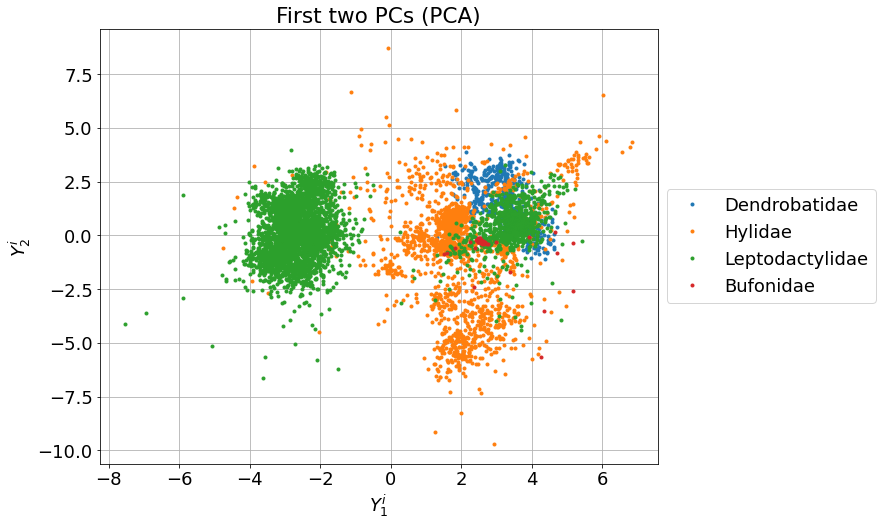

In [83]:
plt.figure(figsize=(10,8))
plt.rcParams['font.size'] = 18

for family_name in families:
    indices = families_indices[family_name]
    plt.plot(Y_learning[indices,0],Y_learning[indices,1],'.',label=family_name)
plt.xlabel("$Y_1^i$")
plt.ylabel("$Y_2^i$")
plt.grid("on")
plt.title("First two PCs (PCA)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [84]:
def compute_mutual_info(y1,y2):

    families = ['Dendrobatidae', 'Leptodactylidae', 'Hylidae', 'Bufonidae']
    
    nsamples = len(y1)
    p_y1 = {}
    p_y2 = {}
    p_joint = {}
    
    for family_name1 in families:
        p_y1[family_name1] = 0.
        p_y2[family_name1] = 0.
        for family_name2 in families:
            p_joint[family_name1,family_name2] = 0.
    
    for j in range(nsamples):
        p_y1[y1[j]] += 1./nsamples
        p_y2[y2[j]] += 1./nsamples
        p_joint[y1[j],y2[j]] += 1./nsamples

    I = 0
    entropy1 = 0
    entropy2 = 0
    for y1_i in families:
        if p_y1[y1_i] != 0:
            entropy1 -= p_y1[y1_i]*np.log(p_y1[y1_i])
        if p_y2[y1_i] != 0:
            entropy2 -= p_y2[y1_i]*np.log(p_y2[y1_i])
        for y2_j in families:
            if p_joint[y1_i,y2_j] != 0:
                I += p_joint[y1_i,y2_j]*np.log(p_joint[y1_i,y2_j]/(p_y1[y1_i]*p_y2[y2_j]))
                
    # compute normalized mutual information
    I_normalized = 2*I / (entropy1+entropy2)
                
    return I, I_normalized

In [85]:
k_values = range(1,11)
mutual_info_PCA = []
mutual_info_normalized_PCA = []

for k in k_values:
    PCs_test = Y_test[:,:k]
    PCs_learning = Y_learning[:,:k]
    
    # apply multinomil logistic regression in the learning data set, using 'alpha' PCs
    model = (LogisticRegression(random_state=0, multi_class='multinomial', penalty='none', 
                                solver='newton-cg').fit(PCs_learning,labels_learning))
    
    # make a prediction based on the logistic model using the PCs computed over the test set
    labels_predicted = model.predict(PCs_test)
    
    results = compute_mutual_info(labels_predicted,labels_test)
    mutual_info_PCA.append(results[0])
    mutual_info_normalized_PCA.append(results[1])

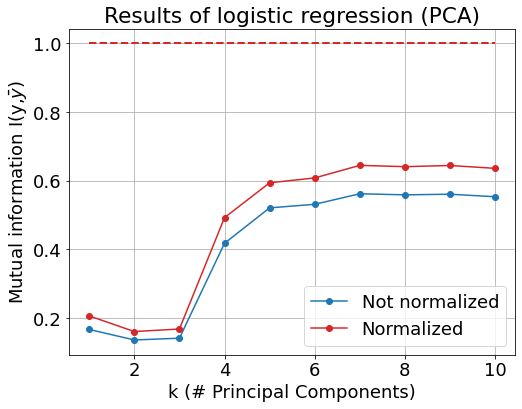

In [86]:
plt.figure(figsize=(8,6))
k_max = 10
plt.plot(np.arange(1,k_max+1),mutual_info_PCA,'o-',label="Not normalized")
plt.plot(np.arange(1,k_max+1),mutual_info_normalized_PCA,'o-',color='tab:red',label="Normalized")
plt.plot(np.arange(1,k_max+1),np.ones(k_max),'--',color='tab:red',linewidth=2)
plt.xlabel("k (# Principal Components)")
plt.ylabel("Mutual information I(y,$\\bar{y}$)")
plt.title("Results of logistic regression (PCA)")
plt.legend()
plt.grid("on")

## 7.2) K-PCA

In [87]:
numbers_nn = [5,50,100]
sigmas = []
for order in numbers_nn:
    sigmas.append(average_distance_nn(data,order=order))
    print("Average distance of " + str(order) + "th nearest neighbor: " + "{:.3f}".format(sigmas[-1]))

Average distance of 5th nearest neighbor: 1.407
Average distance of 50th nearest neighbor: 1.994
Average distance of 100th nearest neighbor: 2.290


In [88]:
kernel_matrix = {}
for sigma in sigmas:
    kernel_matrix[sigma] = compute_kernel_matrix(data,sigma)

In [89]:
start_time = time.time()

gram_matrix = {}
for sigma in sigmas:
    gram_matrix[sigma] = double_centering(kernel_matrix[sigma],case='kernel')
    
print("Execution time: {:.1f} minutes".format((time.time() - start_time)/60))

Execution time: 5.0 minutes


In [90]:
for sigma in sigmas:
    zero_sums = True
    for raw in range(gram_matrix[sigma].shape[0]):
        zero_sums *= (np.abs(np.sum(gram_matrix[sigma][raw,:])) < 1e-8)
    print("sigma = {:.3f}".format(sigma)+": is Gram matrix property satisfied within numerical accuracy? " + str(bool(zero_sums)))

sigma = 1.407: is Gram matrix property satisfied within numerical accuracy? True
sigma = 1.994: is Gram matrix property satisfied within numerical accuracy? True
sigma = 2.290: is Gram matrix property satisfied within numerical accuracy? True


In [91]:
# optimized routine for symmetric real matrices, returning only the first k_max eigenvalues and eigenvectors
k_max = 100
eigenvalues_kPCA = {}
eigenvectors_kPCA = {}
for sigma in sigmas:
    eigenvalues_kPCA[sigma], eigenvectors_kPCA[sigma] = scipy.linalg.eigh(gram_matrix[sigma],subset_by_index=[N-k_max,N-1]) #np.linalg.eigh(gram_matrix) 
    eigenvalues_kPCA[sigma] = np.flip(eigenvalues_kPCA[sigma])  # by default in ascending order
    eigenvectors_kPCA[sigma] = np.flip(eigenvectors_kPCA[sigma],axis=1)

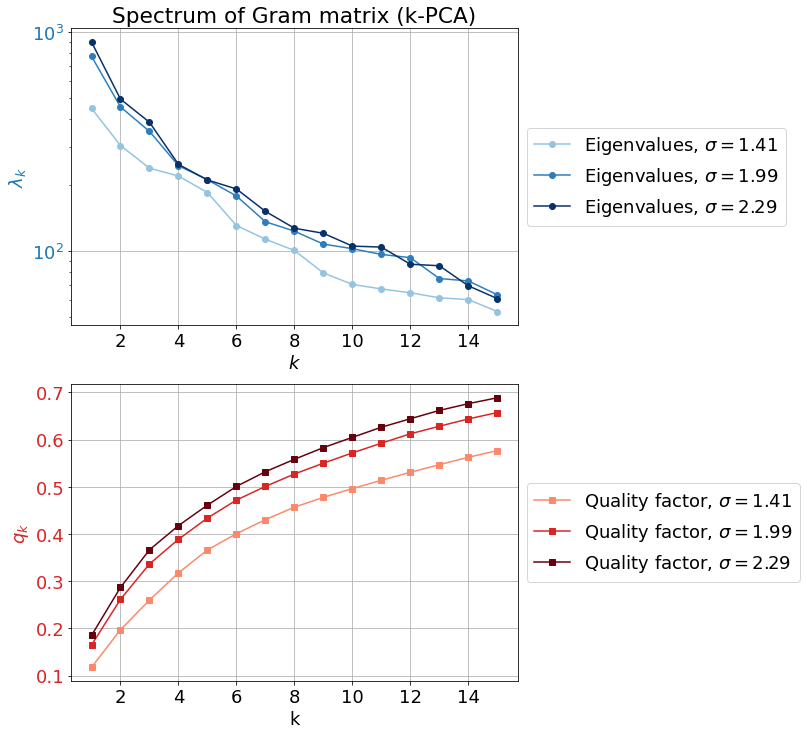

In [92]:
plt.rcParams['font.size'] = 18
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,12))
k_max = 15

colors = plt.cm.Blues(np.linspace(0.4,1.,3))
i = 0
lns = {}
for sigma in sigmas:
    ax1.plot(np.arange(1,k_max+1),eigenvalues_kPCA[sigma][:k_max],'o-',
                      color=colors[i],label="Eigenvalues, $\sigma = {:.2f}$".format(sigma))
    i+=1
ax1.set(xlabel="$k$",title="Spectrum of Gram matrix (k-PCA)",yscale="log")
ax1.set_ylabel(ylabel="$\\lambda_k$",color='tab:blue')
ax1.grid("on")
ax1.tick_params(axis='y',labelcolor='tab:blue')
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

colors = plt.cm.Reds(np.linspace(0.4,1.,3))
for sigma in sigmas:
    ax2.plot(np.arange(1,k_max+1),np.cumsum(eigenvalues_kPCA[sigma][:k_max])/np.sum(eigenvalues_kPCA[sigma]),
                's-',color=colors[i-3],label="Quality factor, $\sigma = {:.2f}$".format(sigma))
    i+=1
ax2.set_ylabel("$q_k$",color='tab:red')
ax2.set_xlabel("k")
ax2.tick_params(axis='y',labelcolor='tab:red')
ax2.grid("on")
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.subplots_adjust(hspace=0.2)
plt.show()

In [93]:
for sigma in sigmas:
    q2 = (eigenvalues_kPCA[sigma][0] + eigenvalues_kPCA[sigma][1]) / np.sum(eigenvalues_kPCA[sigma])
    print("q2 = " + "{:.5f}".format(q2))

q2 = 0.19733
q2 = 0.26178
q2 = 0.28700


In [94]:
k_max = 10
N = len(data)
Y_kPCA = {}
for sigma in sigmas:
    Y_kPCA[sigma] = np.zeros((N,k_max)) # Y_j,k (first component: # of PC, second component: data point label)
    for k in range(k_max):
        Y_kPCA[sigma][:,k] = eigenvectors_kPCA[sigma][:,k]*np.sqrt(eigenvalues_kPCA[sigma][k])

Plot the two first PCs and color them by the level:

In [95]:
families = []
families_indices = {}
for i in np.arange(N):
    family_name = labels[i]
    if (family_name not in families): 
        families.append(family_name)
        families_indices[family_name] = []
    families_indices[family_name].append(i)
        
print("Distinct families: " + str(families))

Distinct families: ['Leptodactylidae', 'Hylidae', 'Dendrobatidae', 'Bufonidae']


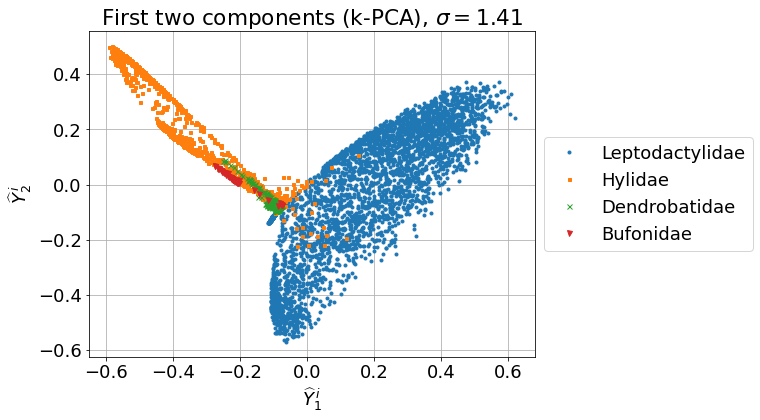

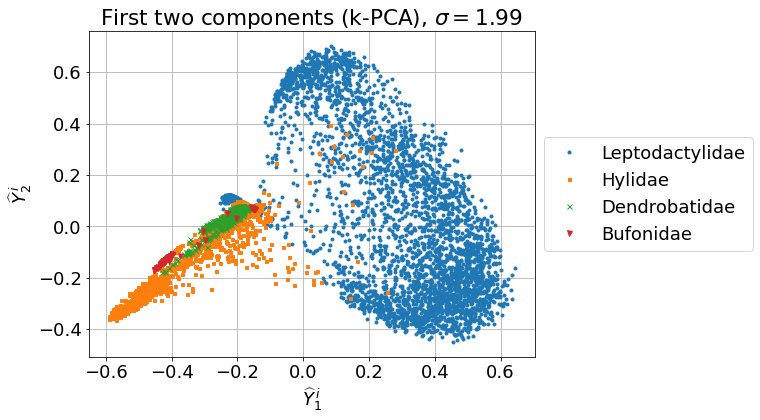

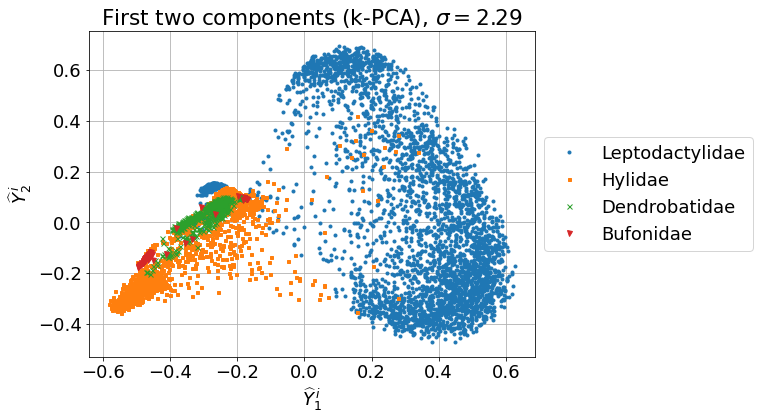

In [96]:
for sigma in sigmas:   
    plt.figure(figsize=(8,6))
    plt.rcParams['font.size'] = 18

    markers = ['o','s','x','v']
    markersizes = [3,3,5,5]
    i = 0
    for family_name in families:
        indices = families_indices[family_name]
        (plt.plot(Y_kPCA[sigma][indices,0],Y_kPCA[sigma][indices,1],markers[i],markersize=markersizes[i],
                  label=str(family_name)))
        i += 1

    plt.xlabel("$\widehat{Y}_1^{\,i}$")
    plt.ylabel("$\widehat{Y}_2^{\,i}$")
    plt.grid("on")
    plt.title("First two components (k-PCA), $\sigma = {:.2f}$".format(sigma))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [97]:
k_values = range(1,11)
mutual_info_kPCA = {}
mutual_info_normalized_kPCA = {}
for sigma in sigmas:
    mutual_info_kPCA[sigma] = []
    mutual_info_normalized_kPCA[sigma] = []
    for k in k_values:
        PCs_test = Y_kPCA[sigma][:N_test,:k]
        PCs_learning = Y_kPCA[sigma][N_test:,:k]

        # apply multinomial logistic regression in the learning data set, using k PCs
        model = (LogisticRegression(random_state=0, multi_class='multinomial', penalty='none', 
                                    solver='newton-cg').fit(PCs_learning,labels_learning))

        # make a prediction based on the logistic model using the PCs computed over the test set
        labels_predicted = model.predict(PCs_test)

        results = compute_mutual_info(labels_predicted,labels_test)
        mutual_info_kPCA[sigma].append(results[0])
        mutual_info_normalized_kPCA[sigma].append(results[1])

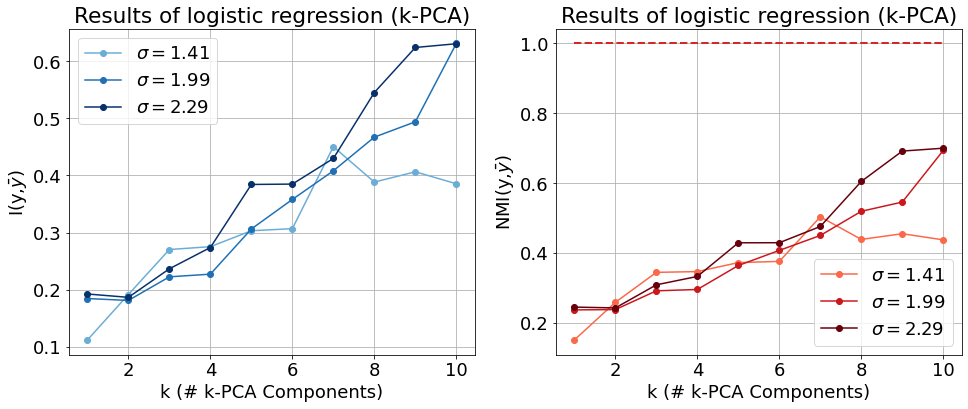

In [98]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,6))

blues = plt.cm.Blues(np.linspace(0.5,1.,3))
reds = plt.cm.Reds(np.linspace(0.5,1.,3))
i = 0
for sigma in sigmas:
    ax1.plot(np.arange(1,k_max+1),mutual_info_kPCA[sigma],'o-',color=blues[i],label="$\sigma = {:.2f}$".format(sigma))
    ax2.plot(np.arange(1,k_max+1),mutual_info_normalized_kPCA[sigma],'o-',color=reds[i],label="$\sigma = {:.2f}$".format(sigma))
    i += 1
ax2.plot(np.arange(1,k_max+1),np.ones(k_max),'--',color='tab:red',linewidth=2)
ax1.set(xlabel="k (# k-PCA Components)",ylabel="I(y,$\\bar{y}$)",
        title="Results of logistic regression (k-PCA)")
ax2.set(xlabel="k (# k-PCA Components)",ylabel="NMI(y,$\\bar{y}$)",
        title="Results of logistic regression (k-PCA)")
ax1.legend(loc='best')
ax2.legend(loc='best')
ax1.grid("on")
ax2.grid("on")

### 7.3) Isomap

In [99]:
start_time = time.time()
distance_graph = initialize_graph(data,nn_cutoff=20)
print("Execution time: {:.1f} minutes".format((time.time() - start_time)/60))

Execution time: 1.7 minutes


In [100]:
start_time = time.time()
distance_graph = floyd_algorithm(distance_graph)
print("Execution time: {:.1f} minutes".format((time.time() - start_time)/60))

Execution time: 4.7 minutes


In [101]:
connected = not np.isinf(distance_graph).any()
if connected: print("The graph is connected")
else: print("The graph is not connected")

The graph is connected


In [102]:
start_time = time.time()
gram_matrix = double_centering(distance_graph**2, case='isomap')
print("Execution time: {:.1f} minutes".format((time.time() - start_time)/60))

Execution time: 1.7 minutes


In [103]:
zero_sums = True
for raw in range(gram_matrix.shape[0]):
    zero_sums *= (np.abs(np.sum(gram_matrix[raw,:])) < 1e-7)
print("Is Gram matrix property satisfied within numerical accuracy? " + str(bool(zero_sums)))

Is Gram matrix property satisfied within numerical accuracy? True


In [104]:
# optimized routine for symmetric real matrices, returning only the first k_max eigenvalues and eigenvectors
k_max = 100
eigenvalues_isomap, eigenvectors_isomap = scipy.linalg.eigh(gram_matrix,subset_by_index=[N-k_max,N-1])
eigenvalues_isomap = np.flip(eigenvalues_isomap)  # by default in ascending order
eigenvectors_isomap = np.flip(eigenvectors_isomap,axis=1)

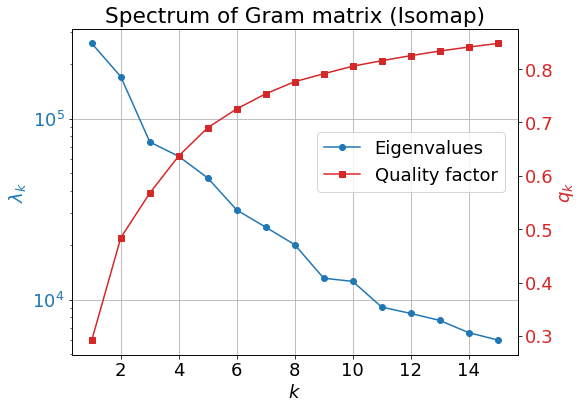

In [105]:
plt.rcParams['font.size'] = 18
fig, ax1 = plt.subplots(figsize=(8,6))
k_max = 15

color = 'tab:blue'
lns1 = ax1.plot(np.arange(1,k_max+1),eigenvalues_isomap[:k_max],'o-',color=color,label="Eigenvalues")
ax1.set(xlabel="$k$",yscale="log",title="Spectrum of Gram matrix (Isomap)")
ax1.set_ylabel(ylabel="$\\lambda_k$",color=color)
ax1.grid("on")
ax1.tick_params(axis='y', labelcolor=color)

color = 'tab:red'
ax2 = ax1.twinx()  
lns2 = ax2.plot(np.arange(1,k_max+1),np.cumsum(eigenvalues_isomap[:k_max])/np.sum(eigenvalues_isomap),'s-',color=color,label="Quality factor")
ax2.set_ylabel("$q_k$",color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax1.legend()

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=[0.55,0.5])
        
plt.show()

In [106]:
k_max = 10
N = len(data)
Y_isomap = np.zeros((N,k_max)) # Y_j,k (first component: # of PC, second component: data point label)
for k in range(k_max):
    Y_isomap[:,k] = eigenvectors_isomap[:,k]*np.sqrt(eigenvalues_isomap[k])

In [107]:
q2 = (eigenvalues_isomap[0] + eigenvalues_isomap[1]) / np.sum(eigenvalues_isomap)
print("q2 = " + "{:.5f}".format(q2))

q2 = 0.48404


In [108]:
families = []
families_indices = {}
for i in np.arange(N):
    family_name = labels[i]
    if (family_name not in families): 
        families.append(family_name)
        families_indices[family_name] = []
    families_indices[family_name].append(i)
        
print("Distinct families: " + str(families))

Distinct families: ['Leptodactylidae', 'Hylidae', 'Dendrobatidae', 'Bufonidae']


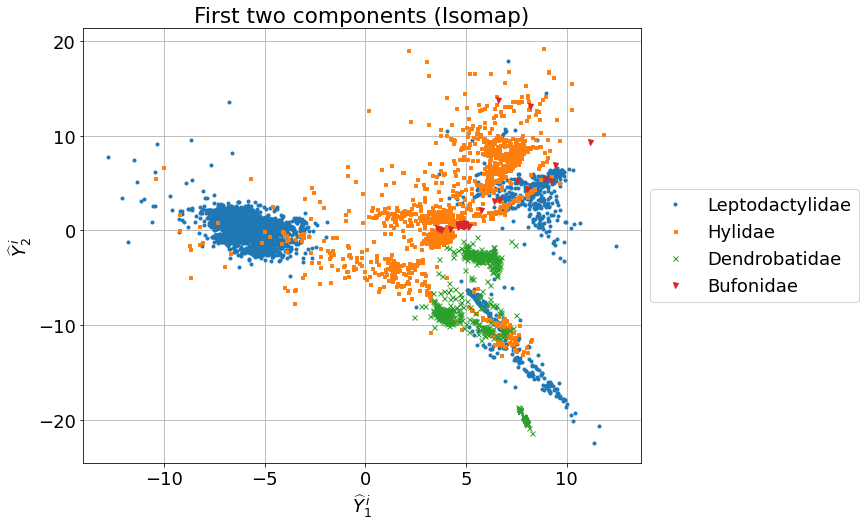

In [109]:
plt.figure(figsize=(10,8))
plt.rcParams['font.size'] = 18

markers = ['o','s','x','v']
markersizes = [3,3,5,5]
i = 0
for label in families:
    indices = families_indices[label]
    plt.plot(Y_isomap[indices,0],Y_isomap[indices,1],markers[i],markersize=markersizes[i],label=str(label))
    i += 1
plt.xlabel("$\widehat{Y}_1^{\,i}$")
plt.ylabel("$\widehat{Y}_2^{\,i}$")
plt.grid("on")
plt.title("First two components (Isomap)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [110]:
k_values = range(1,k_max+1)
mutual_info_isomap = []
mutual_info_normalized_isomap = []
for k in k_values:
    PCs_test = Y_isomap[:N_test,:k]
    PCs_learning = Y_isomap[N_test:,:k]
    
    # apply multinomil logistic regression in the learning data set, using 'alpha' PCs
    model = (LogisticRegression(random_state=0, multi_class='multinomial', penalty='none', 
                                solver='newton-cg').fit(PCs_learning,labels_learning))
    
    # make a prediction based on the logistic model using the PCs computed over the test set
    labels_predicted = model.predict(PCs_test)
    
    results = compute_mutual_info(labels_predicted,labels_test)
    mutual_info_isomap.append(results[0])
    mutual_info_normalized_isomap.append(results[1])

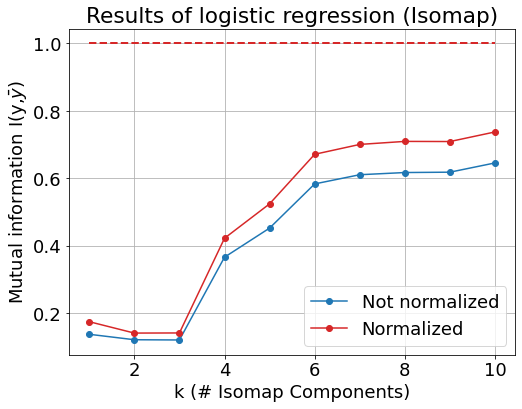

In [111]:
plt.figure(figsize=(8,6))
plt.plot(np.arange(1,k_max+1),mutual_info_isomap,'o-',label="Not normalized")
plt.plot(np.arange(1,k_max+1),mutual_info_normalized_isomap,'o-',label="Normalized",color='tab:red')
plt.plot(np.arange(1,k_max+1),np.ones(k_max),'--',color='tab:red',linewidth=2)
plt.xlabel("k (# Isomap Components)")
plt.ylabel("Mutual information I(y,$\\bar{y}$)")
plt.legend()
plt.title("Results of logistic regression (Isomap)")
plt.grid("on")

## Comparison of the methods: PCA vs k-PCA vs Isomap

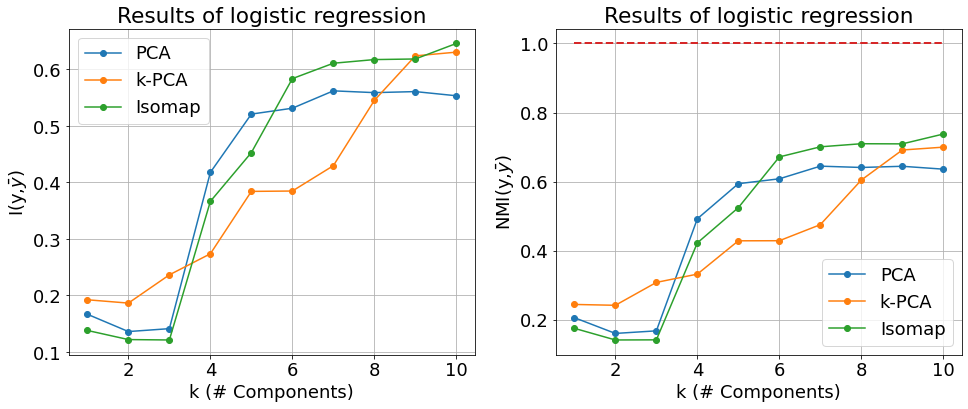

In [112]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,6))

ax1.plot(np.arange(1,k_max+1),mutual_info_PCA,'o-',label="PCA")
ax2.plot(np.arange(1,k_max+1),mutual_info_normalized_PCA,'o-',label="PCA")

sigma = sigmas[-1]
ax1.plot(np.arange(1,k_max+1),mutual_info_kPCA[sigma],'o-',label="k-PCA")
ax2.plot(np.arange(1,k_max+1),mutual_info_normalized_kPCA[sigma],'o-',label="k-PCA")

ax1.plot(np.arange(1,k_max+1),mutual_info_isomap,'o-',label="Isomap")
ax2.plot(np.arange(1,k_max+1),mutual_info_normalized_isomap,'o-',label="Isomap")

ax2.plot(np.arange(1,k_max+1),np.ones(k_max),'--',color='tab:red',linewidth=2)
ax1.set(xlabel="k (# Components)",ylabel="I(y,$\\bar{y}$)",
        title="Results of logistic regression")
ax2.set(xlabel="k (# Components)",ylabel="NMI(y,$\\bar{y}$)",
        title="Results of logistic regression")
ax1.legend(loc='best')
ax2.legend(loc='best')
ax1.grid("on")
ax2.grid("on")